# Churn Prediction Model
##### This project builds a machine learning model to predict whether a customer will churn based on behavioral usage patterns.

In [1]:
#Importing libraries
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [2]:
#Loading the data
training_df = pd.read_csv('customer_churn_dataset-training-master.csv')
testing_df = pd.read_csv('customer_churn_dataset-testing-master.csv')

In [3]:
#Data Health Check
training_df.head()
training_df.info()
training_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [4]:
training_df.isnull().sum()

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [5]:
#removing row with missing value
training_df = training_df.dropna()

In [6]:
training_df.duplicated().sum()

0

<Axes: xlabel='Total Spend'>

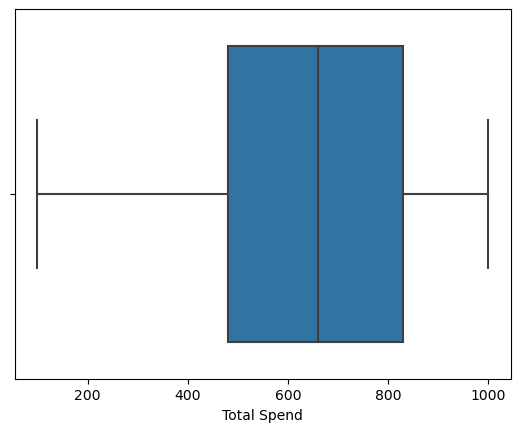

In [7]:
sns.boxplot(x=training_df['Total Spend'])

In [8]:
#Correlation
training_df.corr()['Churn'].sort_values(ascending=False)

C:\Users\KIIT0001\AppData\Local\Temp\ipykernel_33824\1710742682.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  training_df.corr()['Churn'].sort_values(ascending=False)


Churn               1.000000
Support Calls       0.574267
Payment Delay       0.312129
Age                 0.218394
Last Interaction    0.149616
Usage Frequency    -0.046101
Tenure             -0.051919
Total Spend        -0.429355
CustomerID         -0.839365
Name: Churn, dtype: float64

In [9]:
#Imbalance Check
training_df['Churn'].value_counts(normalize=True)

1.0    0.567107
0.0    0.432893
Name: Churn, dtype: float64

In [10]:
Features = ['Usage Frequency', 'Payment Delay', 'Last Interaction']

In [11]:
#Training Model with Logistic Regression
X_train = training_df[Features]
y_train = training_df['Churn']
X_test = testing_df[Features]
y_test = testing_df['Churn']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test  = scaler.transform(X_test)       

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [12]:
#Checking 
y_prob = model.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

ROC-AUC: 0.8060721142176138


<Axes: >

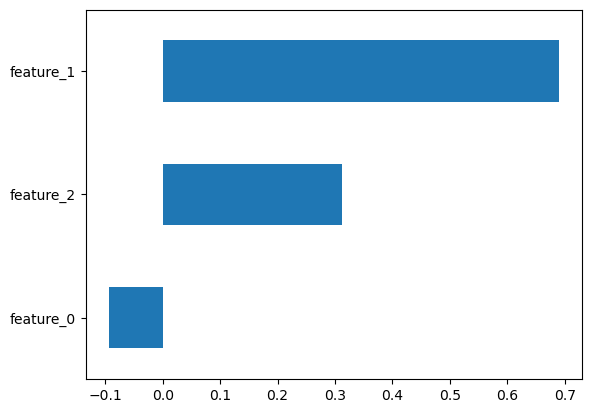

In [13]:
#Checking importance of features used 
# Convert X_test to DataFrame if it's a numpy array
if isinstance(X_test, np.ndarray):
    # If you know the column names, use them here
    feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]  # Replace with actual feature names if known
    importance = pd.Series(model.coef_[0], index=feature_names)
else:
    # If X_test is already a DataFrame
    importance = pd.Series(model.coef_[0], index=X_test.columns)
    
importance.sort_values().plot(kind="barh")

In [14]:
# prediction table
predictions = testing_df.copy()

predictions['Churn_Probability'] = y_prob
predictions['Predicted_Churn'] = (y_prob >= 0.5).astype(int)

In [15]:
#Classifying into categories
def churn_risk(y_prob):
    if y_prob >= 0.75:
        return "High Risk"
    elif y_prob >= 0.40:
        return "Moderate Risk"
    else:
        return "Low Risk"


In [16]:
predictions['Churn_Risk_Level'] = predictions['Churn_Probability'].apply(churn_risk)

In [17]:
predictions['Churn_Risk_Level'].value_counts()

Moderate Risk    33923
High Risk        23431
Low Risk          7020
Name: Churn_Risk_Level, dtype: int64

In [18]:
#Saving the CSV with risk level 
predictions[['CustomerID','Churn_Probability','Churn_Risk_Level']].to_csv(
    "customer_churn_risk_segments.csv", index=False)

In [23]:
import joblib
joblib.dump(model, "churn_model.pkl")

['churn_model.pkl']

In [22]:
with open("model_features.pkl", "wb") as f:
    pickle.dump(Features, f)

print("Feature list saved")

Feature list saved
